In [1]:
def kl_poly(M):
    r"""
    Compute the KL polynomial of the matroid M.

    INPUT:

    M - matroid or graph

    OUTPUT:

    polynomial

    EXAMPLES::

    sage: kl_poly(graphs.PathGraph(2))
    1
    sage: kl_poly(graphs.PathGraph(3))
    1
    sage: kl_poly(graphs.PathGraph(4))
    4*t^2 - 6*t + 4
    """
    if type(M)==Graph:
        M = Matroid(M)
    R.<t> = ZZ['t']
    r = M.rank()
    if r<=2:
        return R(1)
    else:
        LF = M.lattice_of_flats()
        Q = R(0)
        for F in LF:
            if len(F)!=0:
                Fcomplement = M.groundset().difference(F)
                Mloc = M.delete(Fcomplement)
                Mres = M.contract(F)
                chi = ((-1)^Mloc.rank())*Mloc.tutte_polynomial().subs(x=1-t,y=0)
                Q += chi*kl_poly(Mres)
        d = (Integer(M.rank())/2).ceil() - 1
        Qcoeff = Q.coefficients(sparse=False)
        if len(Qcoeff)<d+1:
            Qcoeff = Qcoeff + [0]*(d+1-len(Qcoeff))
        #P = -sum([Qcoeff[i]*t^i for i in [0..d]])+sum([Qcoeff[i]*t^(d-i) for i in [0..d]])
        P = -sum([Qcoeff[i]*t^i for i in [0..d]])
        return P

def ess(M,e):
    r"""
    Given a simple matroid M and e and element of M the is not a coloop,
    calculate the set S in the deletion/contraction formula for KL polynomials.
    ('Simple' means the empty set is a flat and the rank 1 flats are exactly the
    elements of M)

    INPUT:

    M -- Matroid or Graph
    e -- element of M

    OUTPUT:

    list

    EXAMPLES::

    sage: g = graphs.CycleGraph(5)
    sage: ess(g,(0,1))
    [frozenset(),
     frozenset({(0, 4)}),
     frozenset({(1, 2)}),
     frozenset({(2, 3)}),
     frozenset({(3, 4)}),
     frozenset({(0, 4), (1, 2)}),
     frozenset({(0, 4), (2, 3)}),
     frozenset({(0, 4), (3, 4)}),
     frozenset({(1, 2), (2, 3)}),
     frozenset({(1, 2), (3, 4)}),
     frozenset({(2, 3), (3, 4)})]
    sage: g = graphs.DiamondGraph()
    sage: ess(g,(0,1))
    [frozenset(), frozenset({(1, 3)}), frozenset({(2, 3)})]
    sage: ess(g,(1,2))
    [frozenset()]
    """
    if type(M)==Graph:
        M = Matroid(M)
    if e in M.coloops():
        print('e should not be a coloop')
    S = []
    for r in [0..M.rank()]:
        for f in M.flats(r):
            if e not in f:
                g = set(f)
                g.add(e)
                if len(g)==len(M.closure(g)):
                    S.append(f)
    return S

def c(n,i):
    r"""
    Coefficients for the KL polynomial of the cycle graph (the uniform matroid
    of rank n-1 on n elements).

    INPUT:

    n, i - int

    OUTPUT:

    int    

    EXAMPLES::
    """
    if i >= (n-1)/2:
        return 0
    else:
        return binomial(n-i-2,i)*binomial(n,i)/(i+1)

def kl_cycle(n):
    r"""
    The KL polynomial of the n-cycle graph.

    INPUT:

    n - int 

    OUTPUT:

    symbolic expression (representing a polynomial in x)

    EXAMPLES: 
    sage: for i in range(8):
    ....:     kl_cycle(i)
    ....:
    0
    0
    1
    1
    2*x + 1
    5*x + 1
    5*x^2 + 9*x + 1
    21*x^2 + 14*x + 1
    """
    R.<t> = ZZ['t']
    return sum([c(n,i)*t^i for i in range(n)])

def cn_kl_poly_degree(n):
    r"""
    The degree of the KL polynomial of the cycle graph C_n.

    INPUT:

    n - int

    OUTPUT:

    int

    EXAMPLES::
    sage: for i in range(1,15):
    ....:     print(i, kl_cycle(i).degree(x),floor(i/2)-1)
    ....:
    1 0 -1
    2 0 0
    3 0 0
    4 1 1
    5 1 1
    6 2 2
    7 2 2
    8 3 3
    9 3 3
    10 4 4
    11 4 4
    12 5 5
    13 5 5
    14 6 6
    """
    if n < 4:
        return 0
    else:
        return floor(n/2)-1

def c4cn_correction_term(n):
    r"""
    The correction term for the deletion contraction formula for th KL
    polynomial of the cycle graphs C_4 and C_n joined along two consecutive
    edges.

    INPUT:

    n - int

    OUTPUT:

    symbolic expression (representing a polynomial in x)

    EXAMPLES:
    """
    R.<t> = ZZ['t']
    #a = sum([binomial(n-2,k-1)*c(n-3-k,cn_kl_poly_degree(n-3-k))*t^((n-k)/2)
     #   for k in [1..(n-4)] if (n-k)%2==0])
    b = 2*sum([binomial(n-2,k-1)*c(n-k,cn_kl_poly_degree(n-k))*t^((n-k)/2)
        for k in [1..(n-2)] if (n-k)%2==0])
    cc = sum([binomial(n-2,k)*(  c(n-k,cn_kl_poly_degree(n-k)) - c(n-2-k,cn_kl_poly_degree(n-2-k))  )*t^((n-k)/2)
        for k in [0..(n-4)] if (n-k)%2==0])
    #if (n-1)%2==0:
    #    d = (2*c(n-1,cn_kl_poly_degree(n-1)) + c(n-2,cn_kl_poly_degree(n-2)) + (n-2)*(c(n,cn_kl_poly_degree(n)) - c(n-2,cn_kl_poly_degree(n-2))))*t^((n-1)/2)
    #else:
    #    d = 0
    e= 2*(n-2)*t^1
    return b+cc
def c4cn(n):
    R.<t> = ZZ['t']
    return (kl_cycle(n)-t*(kl_cycle(n)-t*kl_cycle(n-2))+c4cn_correction_term(n))
    r"""
    KL_Poly for C_4*C_n

    INPUT:

    n - int

    OUTPUT:

    symbolic expression (representing a polynomial in x)

    EXAMPLES:
                      1*t + 1
                      5*t + 1
             3*t^2 + 10*t + 1
            19*t^2 + 16*t + 1
    9*t^3 + 58*t^2 + 23*t + 1
    """

for i in range(3,15):
    print(c4cn_correction_term(i))
#for i in range(3,8):
 #   g = graphs.CycleGraph(i)
  #  g.add_vertex()
   # g.add_edges([(0,i),(2,i)])
    #print(kl_poly(g)-c4cn(i))

In [103]:
for i in range(3,30): 
    print(c4cn(i))
    print("________________")

t + 1
________________
5*t + 1
________________
3*t^2 + 10*t + 1
________________
19*t^2 + 16*t + 1
________________
9*t^3 + 58*t^2 + 23*t + 1
________________
72*t^3 + 132*t^2 + 31*t + 1
________________
28*t^4 + 293*t^3 + 255*t^2 + 40*t + 1
________________
274*t^4 + 865*t^3 + 443*t^2 + 50*t + 1
________________
90*t^5 + 1389*t^4 + 2105*t^3 + 714*t^2 + 61*t + 1
________________
1047*t^5 + 5035*t^4 + 4494*t^3 + 1088*t^2 + 73*t + 1
________________
297*t^6 + 6347*t^5 + 14784*t^4 + 8722*t^3 + 1587*t^2 + 86*t + 1
________________
4015*t^6 + 27258*t^5 + 37478*t^4 + 15738*t^3 + 2235*t^2 + 100*t + 1
________________
1001*t^7 + 28314*t^6 + 93730*t^5 + 85176*t^4 + 26805*t^3 + 3058*t^2 + 115*t + 1
________________
15444*t^7 + 140504*t^6 + 275184*t^5 + 177828*t^4 + 43560*t^3 + 4084*t^2 + 131*t + 1
________________
3432*t^8 + 124189*t^7 + 553644*t^6 + 717066*t^5 + 346830*t^4 + 68079*t^3 + 5343*t^2 + 148*t + 1
________________
59566*t^8 + 699036*t^7 + 1847496*t^6 + 1701216*t^5 + 639628*t^4 + 1029

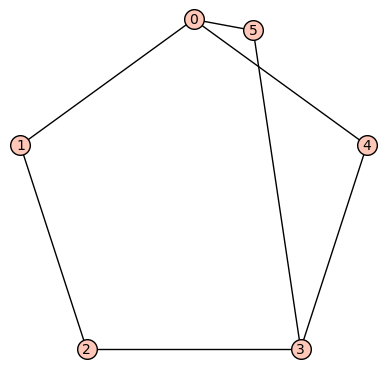

3*t^2 + 10*t + 1


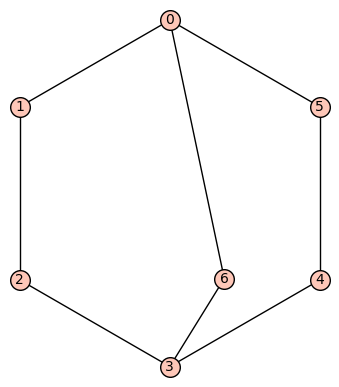

18*t^2 + 17*t + 1


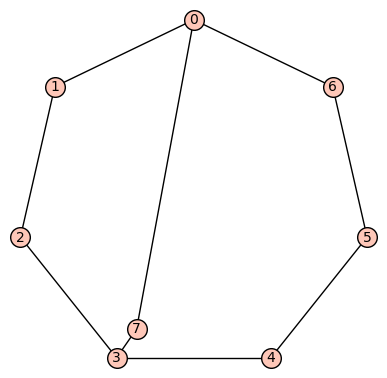

10*t^3 + 58*t^2 + 25*t + 1


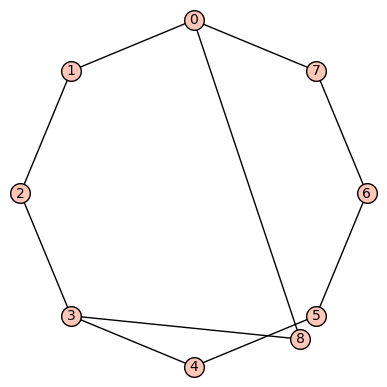

73*t^3 + 137*t^2 + 34*t + 1


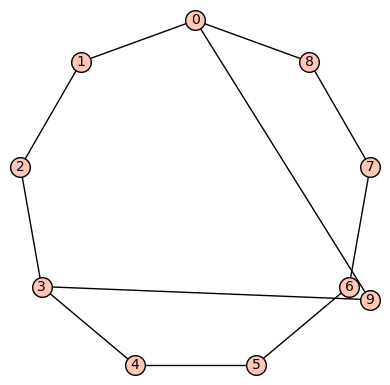

KeyboardInterrupt: 

In [110]:
for i in range(5,10):
    g = graphs.CycleGraph(i)
    g.add_vertex()
    g.add_edges([(0,i),(3,i)])
    g.show()
    print(kl_poly(g))
    #4*t + 1
    #3*t^2 + 10*t + 1
    #18*t^2 + 17*t + 1////// t^2+t is the difference
    #10*t^3 + 58*t^2 + 25*t + 1////// t^3+2t is the difference
    #73*t^3 + 137*t^2 + 34*t + 1///// t^3+5t^2+3t

In [2]:


# This file was *autogenerated* from the file /Users/monroestephenson/Downloads/coeffs_of_c4cn.sage
from sage.all_cmdline import *   # import sage library

_sage_const_3 = Integer(3); _sage_const_4 = Integer(4); _sage_const_1 = Integer(1); _sage_const_2 = Integer(2); _sage_const_0 = Integer(0)
def coeffs_gen_c4cn(n):
    a = [c4cn(i) for i in (ellipsis_range(_sage_const_3 ,Ellipsis,(_sage_const_4 *n+_sage_const_1 )))]
    c = [f.list()[n] for f in a[_sage_const_2 *(n-_sage_const_1 ):]]
    __tmp__=var("x"); v = symbolic_expression([x**i for i in range(_sage_const_2 *n+_sage_const_1 )]).function(x)
    m = matrix(QQ,[v(i) for i in (ellipsis_range(_sage_const_0 ,Ellipsis,(_sage_const_2 *n)))])
    result = factor(m.inverse()*vector(c[:_sage_const_2 *n+_sage_const_3 ])*v(x))
    return result



In [41]:
R.<t> = ZZ['t']
#kl_cycle(5+5-2)-t*(kl_cycle(5-1)*kl_cycle(5-1)) #degree 3
#kl_cycle(5+4-2)-t*(kl_cycle(4-1)*kl_cycle(5-1)) #degree 2
#kl_cycle(8+4-2)-t*(kl_cycle(4-1)*kl_cycle(8-1)) #degree 4
(kl_cycle(20+4-2-1)-t*(kl_cycle(20-1-1)*kl_cycle(4-1))).degree()

9

In [23]:
2*binomial(0,-1)*c(2,cn_kl_poly_degree(2))

0

In [38]:
2*binomial(0,1-1)*c(2-1,cn_kl_poly_degree(2-1))

0

In [53]:
2*sum([binomial(2-2,k-1)*c(2-k,cn_kl_poly_degree(2-k))*x^((2-k)/2) for k in [0..(2-1)] if (2-k)%2==0])

0

In [54]:
2*sum([binomial(2-2,k-1)*c(2-k,cn_kl_poly_degree(2-k))*x^((2-k)/2) for k in [0..(2-1)] if (2-k)%2==0])

0

In [62]:
n=2;
2*sum([binomial(n-2,k-1)*c(n-k,cn_kl_poly_degree(n-k))*t^((n-k)/2) for k in [0..(n-1)] if (n-k)%2==0])

0

In [65]:
c4cn_correction_term(2)

0


0

In [3]:
var('n, j')
f(n,j)=c(n,j)-c(n,j-1)+c(n-2,j-2)+2*binomial(n-2,n-2*j-1)*c(2*j,j-1)+binomial(n-2,n-2*j)*(c(2*j,j-1)-c(2*(j-1),j-2))

In [4]:
f(n,j)*f(n,j)>=f(n,j-1)*f(n,j+1)

((binomial(2*j, j - 1)/j - binomial(2*j - 2, j - 2)/(j - 1))*binomial(n - 2, -2*j + n) + binomial(-j + n - 2, j - 2)*binomial(n - 2, j - 2)/(j - 1) + 2*binomial(2*j, j - 1)*binomial(n - 2, -2*j + n - 1)/j - binomial(-j + n - 1, j - 1)*binomial(n, j - 1)/j + binomial(-j + n - 2, j)*binomial(n, j)/(j + 1))^2 >= -((binomial(2*j - 2, j - 2)/(j - 1) - binomial(2*j - 4, j - 3)/(j - 2))*binomial(n - 2, -2*j + n + 2) + binomial(-j + n - 1, j - 3)*binomial(n - 2, j - 3)/(j - 2) + 2*binomial(2*j - 2, j - 2)*binomial(n - 2, -2*j + n + 1)/(j - 1) + binomial(-j + n - 1, j - 1)*binomial(n, j - 1)/j - binomial(-j + n, j - 2)*binomial(n, j - 2)/(j - 1))*((binomial(2*j, j - 1)/j - binomial(2*j + 2, j)/(j + 1))*binomial(n - 2, -2*j + n - 2) - binomial(-j + n - 3, j - 1)*binomial(n - 2, j - 1)/j - 2*binomial(2*j + 2, j)*binomial(n - 2, -2*j + n - 3)/(j + 1) - binomial(-j + n - 3, j + 1)*binomial(n, j + 1)/(j + 2) + binomial(-j + n - 2, j)*binomial(n, j)/(j + 1))

In [12]:
n = var('n')
j = var('j')
solve_ineq([f(n,j-1)*f(n,j+1)<=f(n,j)*f(n,j), n>4,j>2],[n,j])

[[4 < n,
  2 < j,
  -j^6*binomial(-j + n - 2, j - 2)^2*binomial(n - 2, j - 2)^2 + j^6*binomial(-j + n - 1, j - 3)*binomial(-j + n - 3, j - 1)*binomial(n - 2, j - 1)*binomial(n - 2, j - 3) + j^6*binomial(2*j - 2, j - 2)*binomial(-j + n - 3, j - 1)*binomial(n - 2, j - 1)*binomial(n - 2, -2*j + n + 2) - j^6*binomial(2*j - 4, j - 3)*binomial(-j + n - 3, j - 1)*binomial(n - 2, j - 1)*binomial(n - 2, -2*j + n + 2) + 2*j^6*binomial(2*j - 2, j - 2)*binomial(-j + n - 3, j - 1)*binomial(n - 2, j - 1)*binomial(n - 2, -2*j + n + 1) - 2*j^6*binomial(2*j, j - 1)*binomial(-j + n - 2, j - 2)*binomial(n - 2, j - 2)*binomial(n - 2, -2*j + n) + 2*j^6*binomial(2*j - 2, j - 2)*binomial(-j + n - 2, j - 2)*binomial(n - 2, j - 2)*binomial(n - 2, -2*j + n) - j^6*binomial(2*j, j - 1)^2*binomial(n - 2, -2*j + n)^2 + 2*j^6*binomial(2*j, j - 1)*binomial(2*j - 2, j - 2)*binomial(n - 2, -2*j + n)^2 - j^6*binomial(2*j - 2, j - 2)^2*binomial(n - 2, -2*j + n)^2 - 4*j^6*binomial(2*j, j - 1)*binomial(-j + n - 2, j - 2)*b

In [15]:
n = var('n')
j = var('j')
solve_ineq([c(n,j-1)*c(n,j+1)<=c(n,j)*c(n,j), n>4,j>2],[n,j])

[[4 < n,
  2 < j,
  j^2*binomial(-j + n - 1, j - 1)*binomial(-j + n - 3, j + 1)*binomial(n, j + 1)*binomial(n, j - 1) - j^2*binomial(-j + n - 2, j)^2*binomial(n, j)^2 + 2*j*binomial(-j + n - 1, j - 1)*binomial(-j + n - 3, j + 1)*binomial(n, j + 1)*binomial(n, j - 1) - 2*j*binomial(-j + n - 2, j)^2*binomial(n, j)^2 + binomial(-j + n - 1, j - 1)*binomial(-j + n - 3, j + 1)*binomial(n, j + 1)*binomial(n, j - 1) == 0,
  j + 2 != 0,
  j + 1 != 0,
  j != 0],
 [4 < n,
  2 < j,
  -j^2*binomial(-j + n - 1, j - 1)*binomial(-j + n - 3, j + 1)*binomial(n, j + 1)*binomial(n, j - 1) + j^2*binomial(-j + n - 2, j)^2*binomial(n, j)^2 - 2*j*binomial(-j + n - 1, j - 1)*binomial(-j + n - 3, j + 1)*binomial(n, j + 1)*binomial(n, j - 1) + 2*j*binomial(-j + n - 2, j)^2*binomial(n, j)^2 - binomial(-j + n - 1, j - 1)*binomial(-j + n - 3, j + 1)*binomial(n, j + 1)*binomial(n, j - 1) > 0]]

In [169]:
def cmcn_degree_term(m,n,k,j):
    r"""
    The correction term for the deletion contraction formula for th KL
    polynomial of the cycle graphs C_4 and C_n joined along two consecutive
    edges.

    INPUT:

    n - int
    m - int

    OUTPUT:

    symbolic expression (representing a polynomial in x)

    EXAMPLES:
    """
    q= (kl_cycle(m+n-2-k-j)-t*(kl_cycle(m-1-k)*kl_cycle(n-1-j)))
    l= q.degree()
    r=q.coefficients(sparse=False)
    return r[l]
def cmcn_correction_term(n,m):
    r"""
    The correction term for the deletion contraction formula for th KL
    polynomial of the cycle graphs C_4 and C_n joined along two consecutive
    edges.

    INPUT:

    n - int
    m - int

    OUTPUT:

    symbolic expression (representing a polynomial in x)

    EXAMPLES:
    
    c5c5=5*t^3 + 21*t^2 + 9*t
    c5c6=29*t^3 + 50*t^2 + 12*t
    
    """
    R.<t> = ZZ['t']
    b = sum([binomial(n-2,j)*sum([binomial(m-2,k)*c(m-k-2,cn_kl_poly_degree(m-k-2))*c(n-j-2,cn_kl_poly_degree(n-j-2))*t^((n-k-j-1)/2)
        for k in [0..(n-4)] if (n-k-j-1)%2==0]) for j in [0..(m-4)]])
    cc = sum([binomial(n-2,j)*sum([binomial(m-2,k)*cmcn_degree_term(m,n,k,j)*t^((n-k-j)/2)
        for k in [0..(n-4)] if (n-k-j)%2==0]) for j in [0..(m-4)]])
    return b+cc
def cmcn(n,m):
    R.<t> = ZZ['t']
    return (kl_cycle(n+m-4)-t*(kl_cycle(n+m-4)-t*kl_cycle(n-2)*kl_cycle(m-2)))#+cmcn_correction_term(n,m))
    r"""
    KL_Poly for C_m*C_n

    INPUT:

    n - int
    m - int

    OUTPUT:

    symbolic expression (representing a polynomial in x)

    EXAMPLES:
                      1*t + 1
                      5*t + 1
             3*t^2 + 10*t + 1
            19*t^2 + 16*t + 1
    9*t^3 + 58*t^2 + 23*t + 1
    
    #3*t^2 + 10*t + 1
    #18*t^2 + 17*t + 1
    #10*t^3 + 58*t^2 + 25*t + 1
    #73*t^3 + 137*t^2 + 34*t + 1
    """

In [171]:
cmcn_correction_term(5,6)

84*t^2 + 48*t

In [159]:
10*t^3 + 58*t^2 + 25*t + 1-cmcn(5,6)

29*t^3 + 50*t^2 + 12*t

In [104]:
def cmcn_correction_term(n, m):
    R.<t> = ZZ['t']
    b = sum([sum([binomial(m - 2, k) * binomial(n - 2, j) * c(m - k - 2, cn_kl_poly_degree(m - k - 2)) * c(n - j - 2, cn_kl_poly_degree(n - j - 2)) * t^((n - k - j - 1) / 2)
                for k in [0..(n - 4)] if (n - k - j - 1) % 2 == 0]) for j in [0..(m - 1)]])
    cc = sum([sum([binomial(m - 2, k) * binomial(n - 2, j) * cmcn_degree_term(m, n, k, j) * t^((n - k - j) / 2)
                  for k in [0..(n - 4)] if (n - k - j) % 2 == 0]) for j in [0..(m - 1)]])  # Updated this line
    return b - cc

def cmcn(n, m):
    R.<t> = ZZ['t']
    return (kl_cycle(n + m - 4) - t * (kl_cycle(n + m - 4) - t * kl_cycle(n - 2) * kl_cycle(m - 2)) + cmcn_correction_term(n, m))


In [105]:
cmcn(4,4)

-6*t^2 - t + 1